# Escrow model

In [168]:
import pandas as pd
import numpy as np
import pysnooper as ps
import scipy as sp
import sobol_seq as sobol
import matplotlib.pyplot as plt
import datetime as dt
import scipy.stats as st
import scipy.interpolate as si
import math as mt

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
np.set_printoptions(edgeitems=4, linewidth=100)

class Option():
    """
    Abstract class for pricing European and American options using various modelling approaches.
    """
    
    def __init__(self, callPut, amerEuro, S, K, today, expiry, sigma, r, q, divs, divDates, debug=False):
    
        assert(callPut in ['C', 'P'])
        assert(amerEuro in ['AM', 'EU'])
        assert(S > 0)
        assert(K >= 0)
        assert(today < expiry)
        assert(sigma >= 0)
        assert(len(divs) == len(divDates))
        
        self.callPut  = callPut
        self.amerEuro = amerEuro
        self.S        = S
        self.K        = K
        self.today    = today
        self.expiry   = expiry
        self.sigma    = sigma
        self.r        = r
        self.q        = q
        self.debug    = debug
        
        self.cp       = 1. if callPut == 'C' else -1.
        self.T        = Option.timediff(self.today, self.expiry)
        
        self.divs     = []
        self.divDates = []
        self.divTimes = []
        for div, divDate in zip(divs, divDates):
            if self.today < divDate <= self.expiry:
                self.divs.append(div)
                self.divDates.append(divDate)
                self.divTimes.append(Option.timediff(self.today, divDate))
        
    
    @staticmethod
    def timediff(date1, date2):
        """
        Compute time difference between days, in calendar time
        """
        return (date2 - date1).days / 365.

    
class OptionHybridModel(Option):
    """
    A class to price European and American options based on the 
    escrow model, aka Partial Hybrid Model (see Hull, or Klassen articles).
    """
    
    def printDebug(self, escrow, spots, prices):
        """
        Print debug information
        """
        if self.debug:
            print('Escrow:')
            print(escrow)
            print('Spots:')
            print(spots)
            print('Prices:')
            print(prices)
            
    
    def forward(self):
        """
        Replication based model-independant forward
        """
        dividends = 0.
        for div, divDate in zip(self.divs, self.divDates):
            dividends += div * np.exp((self.r - self.q) * Option.timediff(divDate, self.expiry))
            
        return self.S * np.exp((self.r - self.q) * self.T) - dividends
    
    
    def escrow(self, n, dt):
        """
        Compute escrow value in either partial hybrid model or full hybrid model
        """
        escrow = np.zeros(n + 1)
        
        for i in range(n + 1):
            for div, divTime in zip(self.divs, self.divTimes):
                if i * dt < divTime:
                    escrow[i] += div * np.exp(-(self.r - self.q) * (divTime - i * dt))
                    
        return escrow
    
    
    def priceBlackScholes(self):
        """
        Price European options using Black & Scholes '73 formula
        """
        assert(self.amerEuro == 'EU')
        S = self.S - self.escrow(0, 0)[0]
        
        d1 = (np.log(S / self.K) + (self.r - self.q + 0.5 * self.sigma ** 2) * self.T) / (self.sigma * np.sqrt(self.T))
        d2 = (np.log(S / self.K) + (self.r - self.q - 0.5 * self.sigma ** 2) * self.T) / (self.sigma * np.sqrt(self.T))
    
        if self.callPut == 'C':
            price = (S * np.exp(-self.q * self.T) * st.norm.cdf(d1, 0.0, 1.0) - self.K * np.exp(-self.r * self.T) * st.norm.cdf(d2, 0.0, 1.0))
        
        if self.callPut == 'P':
            price = (self.K * np.exp(-self.r * self.T) * st.norm.cdf(-d2, 0.0, 1.0) - S * np.exp(-self.q * self.T) * st.norm.cdf(-d1, 0.0, 1.0))
            
        return price
    
    
    def priceBlack(self):
        """
        Price European options using Black '76 formula
        """
        assert(self.amerEuro == 'EU')
        
        forward = self.forward()
        
        d1 = (np.log(forward / self.K) + 0.5 * self.sigma ** 2 * self.T) / (self.sigma * np.sqrt(self.T))
        d2 = (np.log(forward / self.K) - 0.5 * self.sigma ** 2 * self.T) / (self.sigma * np.sqrt(self.T))
    
        if self.callPut == 'C':
            price = np.exp(-self.r * self.T) * (forward * st.norm.cdf(d1, 0.0, 1.0) - self.K * st.norm.cdf(d2, 0.0, 1.0))
        
        if self.callPut == 'P':
            price = np.exp(-self.r * self.T) * (self.K * st.norm.cdf(-d2, 0.0, 1.0) - forward * st.norm.cdf(-d1, 0.0, 1.0))
            
        return price
    
    
    def binomialTree(self, spots, n, p, dt):
        """
        Backward price on binomial lattice
        """
        prices = np.zeros((n + 1, n + 1))
        prices[:, n] = np.maximum(self.cp * (spots[:, n] - self.K), 0.)
        
        for i in range(n, 0, -1):
            prices[:i, i - 1] = np.exp(-self.r * dt) * (p * prices[:i, i] + (1. - p) * prices[1:(i + 1), i])
                
            if self.amerEuro == 'AM':
                prices[:i, i - 1] = np.maximum(self.cp * (spots[:i, i - 1] - self.K), prices[:i, i - 1])
                        
        return prices
    
    
    def trinomialTree(self, spots, n, pu, pq, pd, dt):
        """
        Backward price on trinomial lattice
        """
        prices = np.zeros((2 * n + 1, n + 1))
        prices[:, n] = np.maximum(self.cp * (spots[:, n] - self.K), 0.)
        
        for i in range(n, 0, -1):
            prices[:(2 * i - 1), i - 1] = np.exp(-self.r * dt) * (pu * prices[:(2 * i - 1), i] + pq * prices[1:(2 * i), i] + pd * prices[2:(2 * i + 1), i])

            if self.amerEuro == 'AM':
                prices[:(2 * i - 1), i - 1] = np.maximum(self.cp * (spots[:(2 * i - 1), i - 1] - self.K), prices[:(2 * i - 1), i - 1])

        return prices
        
        
    def priceCRR(self, n):
        """
        Price option using CRR binomial tree on spot. 
        Ensure condition to have up-probability in [0, 1].
        Reference:
        - "Option Pricing: A Simplified Approach", Cox, J.C., S.A. Ross and M. Rubinstein (1979)
        """
        dt = self.T / n
        assert((self.r - self.q) ** 2 <= self.sigma ** 2 / dt)
        
        u = np.exp(self.sigma * np.sqrt(dt))
        d = 1. / u
        p = (np.exp((self.r - self.q) * dt) - d) / (u - d)

        escrow = self.escrow(n, dt)
        
        spots = np.zeros((n + 1, n + 1))
        for i in range(n + 1):
            spots[:(i + 1), i] = (self.S - escrow[0]) * u ** (i - 2 * np.arange(i + 1)) + escrow[i]
            
        prices = self.binomialTree(spots, n, p, dt)

        self.printDebug(escrow, spots, prices)

        return prices[0][0]
    
    
    def priceCRRForward(self, n):
        """
        Price option using CRR binomial tree on forward.
        Unconditionally satisfy up-probability in [0, 1].
        Reference:
        - "Option Pricing: A Simplified Approach", Cox, J.C., S.A. Ross and M. Rubinstein (1979)
        """
        dt = self.T / n
        u = np.exp(self.sigma * np.sqrt(dt))
        d = 1. / u
        p = (1. - d) / (u - d)

        escrow = self.escrow(n, dt)
        
        spots = np.zeros((n + 1, n + 1))
        for i in range(n + 1):
            spots[:(i + 1), i] = (self.S - escrow[0]) * u ** (i - 2 * np.arange(i + 1)) * np.exp((self.r - self.q) * i * dt) + escrow[i]
            
        prices = self.binomialTree(spots, n, p, dt)

        self.printDebug(escrow, spots, prices)

        return prices[0][0]
    
    
    def priceJR(self, n):
        """
        Price option using Jarrow Rudd binomial tree on spot.
        Matches moments by definition rather than asymptotically.
        Reference:
        - "Option Pricing", Jarrow, R. and A. Rudd (1983)
        """
        dt = self.T / n
        u = np.exp((self.r - self.q - 0.5 * self.sigma * self.sigma) * dt + self.sigma * np.sqrt(dt))
        d = np.exp((self.r - self.q - 0.5 * self.sigma * self.sigma) * dt - self.sigma * np.sqrt(dt))
        p = (np.exp((self.r - self.q) * dt) - d) / (u - d)

        escrow = self.escrow(n, dt)
        
        spots = np.zeros((n + 1, n + 1))
        for i in range(n + 1):
            for j in range(i + 1):
                spots[j, i] = (self.S - escrow[0]) * u ** (i - j) * d ** j + escrow[i]
            
        prices = self.binomialTree(spots, n, p, dt)

        self.printDebug(escrow, spots, prices)

        return prices[0][0]
    
    
    def priceLR(self, n):
        """
        Price option using Leisen Reimer binomial tree on spot.
        Reference: 
        - "Binomial model for option valuation - examining and improving convergence", Leisen, Reimer
        """
        if n % 2 == 0: n += 1
            
        dt = self.T / n
        escrow = self.escrow(n, dt)
            
        d1 = (np.log((self.S - escrow[0]) / self.K) + (self.r - self.q + 0.5 * self.sigma * self.sigma) * self.T) / self.sigma / np.sqrt(self.T)
        d2 = (np.log((self.S - escrow[0]) / self.K) + (self.r - self.q - 0.5 * self.sigma * self.sigma) * self.T) / self.sigma / np.sqrt(self.T)
        
        term1 = (d1 / (n + 1. / 3. + 0.1 / (n + 1.))) ** 2 * (n + 1. / 6.)
        pp = 0.5 + np.sign(d1) * 0.5 * np.sqrt(1. - np.exp(-term1))
        
        term2 = (d2 / (n + 1. / 3. + 0.1 / (n + 1.))) ** 2 * (n + 1. / 6.)
        p = 0.5 + np.sign(d2) * 0.5 * np.sqrt(1. - np.exp(-term2))
        
        u = np.exp((self.r - self.q) * dt) * pp / p
        d = (np.exp((self.r - self.q) * dt) - p * u) / (1. - p)
        
        spots = np.zeros((n + 1, n + 1))
        for i in range(n + 1):
            for j in range(i + 1):
                spots[j, i] = (self.S - escrow[0]) * u ** (i - j) * d ** j + escrow[i]
            
        prices = self.binomialTree(spots, n, p, dt)

        self.printDebug(escrow, spots, prices)

        return prices[0][0]
    
    
    def priceTrinomial(self, n):
        """
        Price option using a trinomial tree on spot.
        Parameters set to double accuracy of binomial in same number of steps.
        Reference: 
        - "Option Pricing - Mathematical models and computation", p406, Wilmott, Dewynne, Howison
        """
        dt = self.T / n
        assert((self.r - self.q) ** 2 <= self.sigma ** 2 / dt)
        
        u = np.exp(self.sigma * np.sqrt(2 * dt))
        q = 1.
        d = 1. / u
#         p = (np.exp((self.r - self.q) * dt * 0.5) - np.exp(-self.sigma * np.sqrt(0.5 * dt))) / (np.exp(self.sigma * np.sqrt(0.5 * dt)) - np.exp(-self.sigma * np.sqrt(0.5 * dt)))
        p = (1. - np.exp(-self.sigma * np.sqrt(0.5 * dt))) / (np.exp(self.sigma * np.sqrt(0.5 * dt)) - np.exp(-self.sigma * np.sqrt(0.5 * dt)))
        pu = p * p
        pq = 2 * p * (1. - p)
        pd = (1. - p) ** 2

        escrow = self.escrow(n, dt)
        spots = np.zeros((2 * n + 1, n + 1))
        
        for i in range(n + 1):
#             spots[:(2 * i + 1), i] = (self.S - escrow[0]) * u ** (i - np.arange(2 * i + 1)) + escrow[i]
            spots[:(2 * i + 1), i] = (self.S - escrow[0]) * u ** (i - np.arange(2 * i + 1)) * np.exp((self.r - self.q) * i * dt) + escrow[i]
            
        prices = self.trinomialTree(spots, n, pu, pq, pd, dt)

        self.printDebug(escrow, spots, prices)

        return prices[0][0]
    
    
    def pricePDE(self, nSpace, nTime):
        """
        Price option using PDE on log-spot.
        The boundary conditions are that gamma is null on the edges
        """
        
        X0    = np.log(self.S)
        X_max = np.log(6. * self.S)
        X_min = np.log(self.S / 6.)
        
        X, dx = np.linspace(X_min, X_max, nSpace, retstep=True)  
        t, dt = np.linspace(0, self.T, nTime, retstep=True)
        
        V       = np.zeros((nSpace, nTime))
        V[:,-1] = np.maximum(self.cp * (np.exp(X) - self.K), 0.)
        V[-1,:] = np.maximum(self.cp * (np.exp(X_max) - self.K * np.exp(-self.r * t[::-1])), 0.0)
        V[0,:]  = np.maximum(self.cp * (np.exp(X_min) - self.K * np.exp(-self.r * t[::-1])), 0.0)
        
        a = 0.5 * (self.r - self.q - 0.5 * self.sigma**2) * dt / dx - 0.5 * self.sigma**2 * dt / dx**2
        b = (1. + dt * self.sigma**2 / dx**2 + dt * self.r)
        c = - 0.5 * (self.r - self.q - 0.5 * self.sigma**2) * dt / dx - 0.5 * self.sigma**2 * dt / dx**2
        D = sp.sparse.diags([a, b, c], [-1, 0, 1], shape=(nSpace, nSpace)).tocsc()

        D[0, 0]   += 2 * a
        D[0, 1]   += -a
        D[-1, -1] += 2 * c
        D[-1, -2] += -c
#         print(D.todense())  
    
        for i in range(nTime - 2, -1, -1):
            V[:, i] = sp.sparse.linalg.splu(D).solve(V[:, i + 1])

            if self.amerEuro == 'AM':
                V[:,i] = np.maximum(V[:,i], Payoff)  
    
#         D = sp.sparse.diags([a, b, c], [-1, 0, 1], shape=(nSpace - 2, nSpace - 2)).tocsc()
        
#         offset = np.zeros(nSpace - 2)
      
#         for i in range(nTime - 2, -1, -1):
#             offset[0]  = a * V[0, i]
#             offset[-1] = c * V[-1, i]
#             V[1:-1, i] = sp.sparse.linalg.splu(D).solve(V[1:-1, i + 1] - offset)

#             if self.amerEuro == 'AM':
#                 V[1:-1,i] = np.maximum(V[1:-1,i], Payoff[1:-1])

        print(V)
        return np.interp(X0, X, V[:, 0])

In [58]:
nSpace = 51
nTime = 10
self = option
X0    = np.log(self.S)
X_max = np.log(6. * self.K)
X_min = np.log(self.K / 6.)

X, dx = np.linspace(X_min, X_max, nSpace, retstep=True)  
t, dt = np.linspace(0, self.T, nTime, retstep=True)

S = np.exp(X)
V = np.zeros((nSpace, nTime))

V[:,-1] = np.maximum(self.cp * (S - self.K), 0.)

if self.callPut == 'C':
    V[-1,:] = np.exp(X_max) - self.K * np.exp(-self.r * t[::-1])
    V[0,:]  = 0.

if self.callPut == 'P':
    V[-1,:] = 0.
    V[0,:]  = self.K * np.exp(-self.r * t[::-1]) - np.exp(X_min)

a = ((0.5 * dt) * ((self.r - 0.5*self.sigma**2) / dx - self.sigma**2 / dx**2))
b = (1 + dt * (self.sigma**2 / dx**2 + self.r))
c = (-(0.5 * dt) * ((self.r - 0.5*self.sigma**2) / dx + self.sigma**2 / dx**2))

D = sp.sparse.diags([a, b, c], [-1, 0, 1], shape=(nSpace - 2, nSpace - 2)).tocsc()

offset = np.zeros(nSpace - 2)

for i in range(nTime - 2, -1, -1):
    offset[0] = a * V[0,i]
    offset[-1] = c * V[-1,i]
    V[1:-1,i] = sp.sparse.linalg.splu(D).solve(V[1:-1,i+1] - offset)

    if self.amerEuro == 'AM':
        V[1:-1,i] = np.maximum(V[1:-1,i], Payoff[1:-1])

np.interp(X0, X, V[:, 0])

7.733972220488296

## Pricing

In [176]:
today    = dt.date(2019, 11, 4)
expiry   = dt.date(2020, 4, 15)
S        = 100.
K        = 100.
n        = 1000
sigma    = 0.3
r        = 0.0
q        = 0.0
divs     = np.array([2, 2, 2, 2, 2, 2, 2, 2, 2]) * 0.
divDates = [dt.date(2019, 11, 7), dt.date(2020, 2, 7), dt.date(2020, 5, 8), dt.date(2020, 8, 7), dt.date(2020, 11, 6), dt.date(2021, 2, 5), dt.date(2021, 5, 7), dt.date(2021, 8, 6), dt.date(2021, 11, 5)]


option = OptionHybridModel('C', 'EU', S, K, today,expiry, sigma, r, q, divs, divDates, debug=False)
print('Forward: %f' % option.forward())
print('BS:      %f' % option.priceBlackScholes())
print('Black:   %f' % option.priceBlack())
print('CRR:     %f' % option.priceCRR(200))
# print('CRRFwd:  %f' % option.priceCRRForward(n))
# print('JR:      %f' % option.priceJR(n))
# print('Trinom:  %f' % option.priceTrinomial(n))
# print('LR:      %f' % option.priceLR(n))
print('PDE:     %f' % option.pricePDE(200, 200))

# print(Option('C', 'AM', S, K, today, expiry, sigma, r, q, divs, divDates, debug=False).priceCRR(n))

Forward: 100.000000
BS:      7.984576
Black:   7.984576
CRR:     7.974602
[[ 0.994  0.006  0.     0.    ...  0.     0.     0.     0.   ]
 [-0.314  1.623 -0.309  0.    ...  0.     0.     0.     0.   ]
 [ 0.    -0.314  1.623 -0.309 ...  0.     0.     0.     0.   ]
 [ 0.     0.    -0.314  1.623 ...  0.     0.     0.     0.   ]
 ...
 [ 0.     0.     0.     0.    ...  1.623 -0.309  0.     0.   ]
 [ 0.     0.     0.     0.    ... -0.314  1.623 -0.309  0.   ]
 [ 0.     0.     0.     0.    ...  0.    -0.314  1.623 -0.309]
 [ 0.     0.     0.     0.    ...  0.     0.    -0.006  1.006]]
[[ -0.     -0.     -0.     -0.    ...  -0.     -0.     -0.      0.   ]
 [  0.      0.      0.      0.    ...   0.      0.      0.      0.   ]
 [  0.      0.      0.      0.    ...   0.      0.      0.      0.   ]
 [  0.      0.      0.      0.    ...   0.      0.      0.      0.   ]
 ...
 [461.677 461.717 461.758 461.798 ... 468.442 468.444 468.446 468.446]
 [470.823 470.867 470.911 470.955 ... 478.759 478.768 47

In [5]:
%timeit OptionHybridModel('C', 'EU', S, K, today, expiry, sigma, r, q, divs, divDates, debug=False).priceCRR(100)

3.06 ms ± 1.84 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [123]:
%timeit OptionHybridModel('C', 'EU', S, K, today, expiry, sigma, r, q, divs, divDates, debug=False).pricePDE(100, 100)

10.2 ms ± 2.17 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Convergence

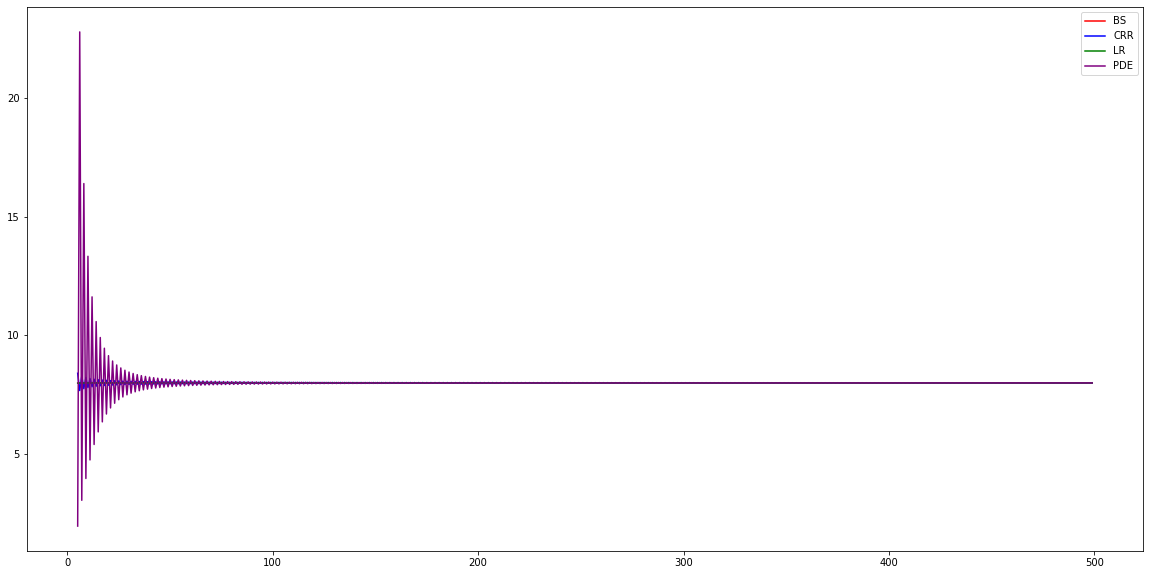

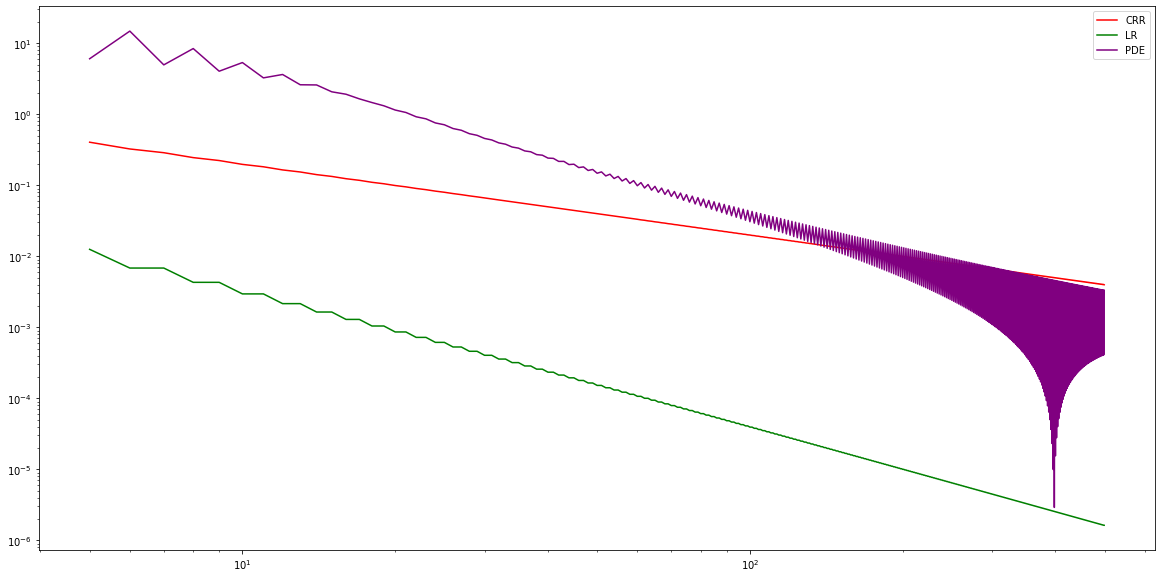

In [102]:
steps = range(5, 300, 1)
priceBS = [option.priceBlackScholes() for n in steps]
priceCRR = [option.priceCRR(n) for n in steps]
# priceCRR = [option.priceCRRForward(n) for n in steps]
# priceJR = [option.priceJR(n) for n in steps]
# priceTri = [option.priceTrinomial(n) for n in steps]
priceLR = [option.priceLR(n) for n in steps]
pricePDE = [option.pricePDE(n, n) for n in steps]

plt.figure(figsize=(20, 10))
plt.plot(steps, priceBS, color='red', label='BS')
plt.plot(steps, priceCRR, color='blue', label='CRR')
# plt.plot(steps, priceJR, color='purple', label='JR')
# plt.plot(steps, priceTri, color='green', label='Trinomial')
plt.plot(steps, priceLR, color='green', label='LR')
plt.plot(steps, pricePDE, color='purple', label='PDE')
plt.legend()

plt.figure(figsize=(20, 10))
plt.loglog(steps, [np.abs(x - y) for x, y in zip(priceCRR, priceBS)], color='red', label='CRR')
# plt.loglog(steps, [np.abs(x - y) for x, y in zip(priceJR, priceBS)], color='blue', label='JR')
# plt.loglog(steps, [np.abs(x - y) for x, y in zip(priceTri, priceBS)], color='green', label='Trinomal')
plt.loglog(steps, [np.abs(x - y) for x, y in zip(priceLR, priceBS)], color='green', label='LR')
plt.loglog(steps, [np.abs(x - y) for x, y in zip(pricePDE, priceBS)], color='purple', label='PDE')
plt.legend()

# Spot Model

In [94]:
class OptionSpotModel(Option):
    """
    A class to price European and American options based on the spot model, aka piecewise GMB model.
    """
    
    def printDebug(self, spots, prices):
        """
        Print debug information
        """
        if self.debug:
            print('Spots:')
            print(spots)
            print('Prices:')
            print(prices)

    
    def priceVN(self, n):
        """
        Price option using a binomial tree on spot, using interpolation to forcefully recombine the tree.
        Adding limit condition for a spot of 0: call is worth 0, put is worth K,
        Reference: 
        - Efficient Pricing of Derivatives on Assets with Discrete Dividends, Vellekoop, M.H. and Nieuwenhuis, J.W.
        """
        
        dt = self.T / n
        assert((self.r - self.q) ** 2 <= self.sigma ** 2 / dt)

        u = np.exp(self.sigma * np.sqrt(dt))
        d = 1. / u
        p = (np.exp((self.r - self.q) * dt) - d) / (u - d)

        dividendSteps = {}
        for div, divTime in zip(self.divs, self.divTimes):
            dividendSteps[int(np.ceil(divTime / dt))] = div
                
        spots = np.zeros((n + 1, n + 1))
        for i in range(n + 1):
            spots[:(i + 1), i] = self.S * u ** (i - 2 * np.arange(i + 1))

        prices = np.zeros((n + 1, n + 1))
        prices[:, n] = np.maximum(self.cp * (spots[:, n] - K), 0.)
        
        for i in range(n - 1, -1, -1):
            prices[:(i+1), i] = np.exp(-self.r * dt) * (p * prices[:(i + 1), i + 1] + (1. - p) * prices[1:(i + 2), i + 1])

            if i in dividendSteps:
                x = np.append(spots[:(i+1), i], 0.)
                y = np.append(prices[:(i+1), i], 0. if self.callPut == 'C' else self.K)
                interpolator = si.interp1d(x, y)
                prices[:(i+1), i] = interpolator(np.maximum(spots[:(i+1), i] - dividendSteps[i], 0.0))

            if self.amerEuro == 'AM':
                prices[:(i+1), i] = np.maximum(self.cp * (spots[:(i+1), i] - self.K), prices[:(i+1), i])
        
        self.printDebug(spots, prices)
        
        return prices[0][0]
    
    
    def priceNR(self, n):
        """
        Price option using a binomial tree on spot, using a non recombining tree.
        Reference: 
        - Financial Numerical Recipes in C++, B. A. Ødegaard
        """
        
        def priceNRinternal(S, T, n, divs, divTimes, depth):
            """
            Internal function required for calling itself recursively
            """
            dt = T / n
            u = np.exp(self.sigma * np.sqrt(dt))
            d = 1. / u
            p = (np.exp((self.r - self.q) * dt) - d) / (u - d)
            nDiv = (int)(np.ceil(divTimes[0] / dt)) if len(divTimes) else n

            spots = np.zeros((nDiv + 1, nDiv + 1))
            for i in range(nDiv + 1):
                spots[:(i + 1), i] = S * u ** (i - 2 * np.arange(i + 1))

            prices = np.zeros((nDiv + 1, nDiv + 1))

            for i in range(nDiv + 1, 0, -1):
                if i == nDiv + 1:
                    if len(divs):
                        for j in range(i):
                            prices[j, i - 1] = priceNRinternal(max(spots[j, i - 1] - divs[0], 0.), T - divTimes[0], n - nDiv, divs[1:], divTimes[1:] - divTimes[0], depth+1)
                    else:
                        prices[:, i - 1] = np.maximum(self.cp * (spots[:, i - 1] - self.K), 0.)
                else:
                    prices[:i, i - 1] = np.exp(-self.r * dt) * (p * prices[:i, i] + (1. - p) * prices[1:(i + 1), i])

                if self.amerEuro == 'AM':
                    prices[:i, i - 1] = np.maximum(self.cp * (spots[:i, i - 1] - K), prices[:i, i - 1])

            return prices[0][0]

        return priceNRinternal(self.S, self.T, n, self.divs, np.array(self.divTimes), 1)

## Pricing

In [103]:
today    = dt.date(2019, 11, 4)
expiry   = dt.date(2020, 11, 4)
S        = 100.
K        = 100.
n        = 100
sigma    = 0.25
r        = 0.1
q        = 0.0
divs     = np.array([2.5, 2.5])
divDates = [dt.date(2020, 2, 4), dt.date(2020, 8, 4)]


option = OptionSpotModel('C', 'AM', S, K, today, expiry, sigma, r, q, divs, divDates, debug=False)
option.divTimes = [0.25, 0.75]
option.T = 1.0
print('VN: %f' % option.priceVN(n))
print('NR: %f' % option.priceNR(n))

VN: 12.102646
NR: 12.023254


## Convergence

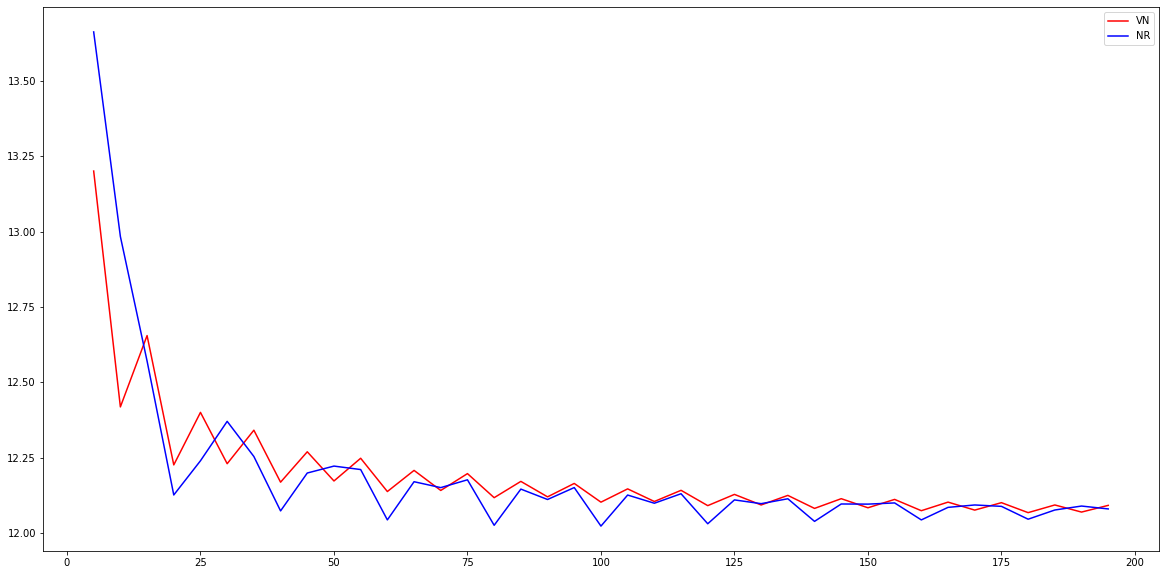

In [105]:
steps = range(5, 200, 5)
priceVN = [option.priceVN(n) for n in steps]
priceNR = [option.priceNR(n) for n in steps]

plt.figure(figsize=(20, 10))
plt.plot(steps, priceVN, color='red', label='VN')
plt.plot(steps, priceNR, color='blue', label='NR')
plt.legend()

# Merton Model

In [10]:
class OptionJumps(Option):
    """
    A class to price European and American options based on Merton's model, aka Black & Scholes with Jumps.
    """
    
    def __init__(self, callPut, amerEuro, S, K, today, expiry, sigma, r, q, divs, divDates, jump_lambda, jump_mu, jump_sigma, debug=False):
    
        assert(jump_sigma >= 0.)
        assert(jump_lambda >= 0.)
    
        super().__init__(callPut, amerEuro, S, K, today, expiry, sigma, r, q, divs, divDates, debug)
        
        self.jump_lambda = jump_lambda
        self.jump_mu = jump_mu
        self.jump_sigma = jump_sigma
        
    
    def priceMerton(self):
        """ 
        Price option using Merton 76' model, using semi-closed form found in the paper.
        Reference:
        - Option pricing when underlying stock returns are discontinuous, Merton, R.C.
        """
        assert(self.amerEuro == 'EU')
        
        def BS(callPut, S, K, T, r, q, sigma):
            d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
            d2 = (np.log(S / K) + (r - q - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))

            if callPut == 'C':
                price = S * np.exp(-q * T) * st.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * st.norm.cdf(d2, 0.0, 1.0)

            if callPut == 'P':
                price = K * np.exp(-r * T) * st.norm.cdf(-d2, 0.0, 1.0) - S * np.exp(-q * T) * st.norm.cdf(-d1, 0.0, 1.0)

            return price
        
        EY = np.exp(self.jump_mu + 0.5 * self.jump_sigma**2)
        l = self.jump_lambda * EY

        price = 0.
        for i in range(18):
            price += \
            np.exp(-l * self.T) * (l * self.T)**i / mt.factorial(i) \
            * BS(
                self.callPut, 
                self.S, 
                self.K, 
                self.T, 
                self.r - self.jump_lambda * (EY - 1.) + i * (self.jump_mu + 0.5 * self.jump_sigma**2) / self.T,
                self.q,
                np.sqrt(self.sigma**2 + (i * self.jump_sigma**2) / self.T)
            )
            
        return price
    
    
    def priceAmin(self, n):
        """
        Price option using Merton '76 Jump Model, discretized on a binomial tree.
        Reference:
        - Jump Diffusion Option Valuation in Discrete Time, K. Amin
        """
        dt = self.T / n
        EY = np.exp(self.jump_mu + 0.5 * self.jump_sigma**2)
        drift = self.r - self.q - 0.5 * self.sigma**2 - self.jump_lambda * (EY - 1.)

        a = (np.exp((self.r - self.q) * dt) - self.jump_lambda * dt * EY) / (1. - self.jump_lambda * dt)
        u = np.exp(drift * dt + self.sigma * np.sqrt(dt))
        d = np.exp(drift * dt - self.sigma * np.sqrt(dt))
        q = (a - d) / (u - d)
        
        Smax = max(int(np.ceil((3 * self.sigma - drift * dt) / (self.sigma * dt))), 2 * n + 1)
        
        states = np.arange(Smax, -(Smax + 1), -1)
        p = st.norm.cdf((drift * dt + (states + 0.5) * self.sigma * np.sqrt(dt)), self.jump_mu, self.jump_sigma) - st.norm.cdf((drift * dt + (states - 0.5) * self.sigma * np.sqrt(dt)), self.jump_mu, self.jump_sigma)
        p = p * self.jump_lambda * dt
        p[Smax] += p[Smax - 1] + p[Smax + 1]
        p[Smax - 1] = (1. - self.jump_lambda * dt) * q
        p[Smax + 1] = (1. - self.jump_lambda * dt) * (1. - q)
        
        M = np.arange(n, -(n + 1), -1)
        
        spots = np.zeros((2 * n + 1, n + 1))
        for i in range(n + 1):
            for j in range(0, 2 * n + 1):
                spots[j, i] = self.S * np.exp(drift * i * dt + (n - j) * self.sigma * np.sqrt(dt))
        
        prices = np.zeros((2 * n + 1, n + 1))
        prices[:, n] = np.maximum(0., self.cp * (spots[:, n] - self.K))
        
        for i in np.arange(n + 1):
            prices[0, i] = np.maximum(0., self.cp * (spots[0, i] - self.K))
            prices[-1, i] = np.maximum(0., self.cp * (spots[-1, i] - self.K))
        
        for i in range(n, 0, -1):
            for j in range(1, 2 * n + 1):
                ptemp = np.copy(p[Smax - j:Smax + 2 * n - j + 1])
                ptemp[0] = np.sum(p[0:Smax + 1 - j])
                ptemp[-1] = np.sum(p[Smax + 2 * n - j:])
                prices[j, i - 1] = np.exp(-self.r * dt) * np.sum(prices[:, i] * ptemp)
            
            if self.amerEuro == 'AM':
                prices[:, i - 1] = np.maximum(prices[:, i - 1], self.cp * (spots[:, i - 1] - K))
        
        return prices[n, 0]
    
    
    def priceMC(self, n):
        """
        Price option using Merton '76 Jump Model, using Monte Carlo
        """
        if n % 2 == 1: n += 1
        
        m = self.jump_lambda * (np.exp(self.jump_mu + 0.5 * self.jump_sigma**2) - 1.)
        W = st.norm.rvs(0., np.sqrt(self.T) * self.sigma, n // 2)
        W = np.concatenate((W, -W))
        N = st.poisson.rvs(self.jump_lambda * self.T, size=n)
        J = np.asarray([st.norm.rvs(self.jump_mu, self.jump_sigma, i).sum() for i in N])
        
        S = self.S * np.exp((self.r - 0.5 * self.sigma**2 - m) * self.T + W + J)
        
        price = np.mean(np.exp(-self.r * self.T) * np.maximum(self.cp * (S - self.K), 0.0))
        return price

In [412]:
today       = dt.date(2019, 11, 4)
expiry      = dt.date(2020, 11, 4)
S           = 40.
K           = 30.
n           = 100
sigma       = np.sqrt(0.05) #0.3
r           = 0.08
q           = 0.0
divs        = np.array([2.5, 2.5]) * 0.
divDates    = [dt.date(2020, 2, 4), dt.date(2020, 8, 4)]
jump_lambda = 5.
jump_sigma  = np.sqrt(0.05)
jump_mu     = -0.5 * jump_sigma**2

option = OptionJumps('P', 'EU', S, K, today, expiry, sigma, r, q, divs, divDates, jump_lambda, jump_mu, jump_sigma, debug=False)
option.T = 1.
print('Merton: %f' % option.priceMerton())
print('Amin:   %f' % option.priceAmin(n))
print('MC:     %f' % option.priceMC(n))

Merton: 2.621097
Amin:   2.602101
MC:     2.261332


# Earnings Model

In [159]:
class OptionEarnings(Option):
    """
    A class to price European and American options an model with BS and jumps deterministic in time
    """
    
    def __init__(self, callPut, amerEuro, S, K, today, expiry, sigma, r, q, divs, divDates, earningDates, earningVols, debug=False):
    
        super().__init__(callPut, amerEuro, S, K, today, expiry, sigma, r, q, divs, divDates, debug)
        
        self.earningDates = []
        self.earningVols  = []
        self.earningTimes = []
        for earningVol, earningDate in zip(earningVols, earningDates):
            if self.today < earningDate <= self.expiry:
                self.earningVols.append(earningVol)
                self.earningDates.append(earningDate)
                self.earningTimes.append(Option.timediff(self.today, earningDate))
    
        self.earningVols = np.array(self.earningVols)
    
    
    def QRGGaussian(self, (n, k)):
        """
        Generate Gaussian samples using Sobol random generator
        """
        return st.norm.rvs(mean, std, (n, k))
#         return st.norm.ppf(sobol.i4_sobol_generate(n, k, 1))
    
    
#     @ps.snoop()
    def priceBlackScholes(self):
        """
        Price European options using Black & Scholes model with jumps
        """
        assert(self.amerEuro == 'EU')
        sigma = np.sqrt(self.sigma**2 + np.sum(self.earningVols**2) / self.T)
        
        d1 = (np.log(self.S / self.K) + (self.r - self.q + 0.5 * sigma ** 2) * self.T) / (sigma * np.sqrt(self.T))
        d2 = (np.log(self.S / self.K) + (self.r - self.q - 0.5 * sigma ** 2) * self.T) / (sigma * np.sqrt(self.T))
    
        if self.callPut == 'C':
            price = (self.S * np.exp(-self.q * self.T) * st.norm.cdf(d1, 0.0, 1.0) - self.K * np.exp(-self.r * self.T) * st.norm.cdf(d2, 0.0, 1.0))
        
        if self.callPut == 'P':
            price = (self.K * np.exp(-self.r * self.T) * st.norm.cdf(-d2, 0.0, 1.0) - self.S * np.exp(-self.q * self.T) * st.norm.cdf(-d1, 0.0, 1.0))
            
        return price
    
#     @ps.snoop()
    def priceMC(self, n):
        """
        Price option using MC
        """
        if n % 2 == 1: n += 1
        
        W = st.norm.rvs(0., np.sqrt(self.T) * self.sigma, n // 2)
        W = np.concatenate((W, -W))
        jumps = st.norm.rvs(0., 1., (n // 2, len(self.earningVols)))
        jumps = np.concatenate((jumps, -jumps))
        J = np.sum(jumps * self.earningVols, axis=1) - 0.5 * np.sum(self.earningVols**2)
        
        S = self.S * np.exp((self.r - 0.5 * self.sigma**2) * self.T + W + J)
        
        price = np.mean(np.exp(-self.r * self.T) * np.maximum(self.cp * (S - self.K), 0.0))
        return price

    
    def pricePDE(self, nSpace, nTime):
        """
        Price option using PDE
        """
        
        X0    = np.log(self.S0)
        X_max = np.log(6. * self.K)
        X_min = np.log(self.K / 6.)
        
        X, dx = np.linspace(X_min, X_max, nSpace, retstep=True)  
        t, dt = np.linspace(0, self.T, nTime, retstep=True)
        
        S = np.exp(X)
        V = np.zeros((nSpace, nTime))
        
        if self.callPut == 'C':
            V[:,-1] = np.maximum(S - self.K, 0.)
            V[-1,:] = np.exp(X_max) - self.K * np.exp(-self.r * t[::-1])
            V[0,:]  = 0.
            
        if self.callPut == 'P':
            V[:,-1] = np.maximum(self.K - S, 0.)
            V[-1,:] = 0.
            V[0,:]  = self.K * np.exp(-self.r * t[::-1]) - np.exp(X_min)
        
        a = ((0.5 * dt) * ((self.r - 0.5*self.sigma**2) / dx - self.sigma**2 / dx**2))
        b = (1 + dt * (self.sigma**2 / dx**2 + self.r))
        c = (-(0.5 * dt) * ((self.r - 0.5*self.sigma**2) / dx + self.sigma**2 / dx**2))
        
        D = sparse.diags([a, b, c], [-1, 0, 1], shape=(nSpace - 2, nSpace - 2)).tocsc()
        offset = np.zeros(nSpace - 2)
      
        for i in range(Ntime-2, -1, -1):
            offset[0] = a * V[0,i]
            offset[-1] = c * V[-1,i]
            V[1:-1,i] = splu(D).solve(V[1:-1,i+1] - offset)

            if self.amerEuro == 'AM':
                V[1:-1,i] = np.maximum(V[1:-1,i], Payoff[1:-1])
        
        return np.interp(x0, x, V[:,0])

In [158]:
today         = dt.date(2019, 11, 4)
expiry        = dt.date(2020, 11, 4)
S             = 40.
K             = 40.
n             = 100000000
sigma         = 0.3
r             = 0.0
q             = 0.0
divs          = np.array([2.5, 2.5]) * 0.
divDates      = [dt.date(2020, 2, 4), dt.date(2020, 8, 4)]
earningDates  = [dt.date(2020, 2, 4), dt.date(2020, 5, 4)]
earningVols   = [0.04, 0.05]

option = OptionEarnings('P', 'EU', S, K, today, expiry, sigma, r, q, divs, divDates, earningDates, earningVols, debug=False)
print('Merton: %f' % option.priceBlackScholes())
print('MC:     %f' % option.priceMC(n))

Starting var:.. self = <__main__.OptionEarnings object at 0x0000016AF66A2080>
18:14:54.825915 call        22     def priceBlackScholes(self):
18:14:54.825915 line        26         assert(self.amerEuro == 'EU')
18:14:54.825915 line        27         sigma = np.sqrt(self.sigma**2 + np.sum(self.earningVols**2) / self.T)
New var:....... sigma = 0.30673897341910705
18:14:54.826914 line        29         d1 = (np.log(self.S / self.K) + (self.r - self.q + 0.5 * sigma ** 2) * self.T) / (sigma * np.sqrt(self.T))
New var:....... d1 = 0.15357943819280123
18:14:54.826914 line        30         d2 = (np.log(self.S / self.K) + (self.r - self.q - 0.5 * sigma ** 2) * self.T) / (sigma * np.sqrt(self.T))
New var:....... d2 = -0.15357943819280123
18:14:54.826914 line        32         if self.callPut == 'C':
18:14:54.826914 line        35         if self.callPut == 'P':
18:14:54.826914 line        36             price = (self.K * np.exp(-self.r * self.T) * st.norm.cdf(-d2, 0.0, 1.0) - self.S * np.exp(-s

Merton: 4.882346


New var:....... W = array([-0.204,  0.334, -0.124,  0.321, ...,  0.655,  0.218, -0.417,  0.282])
18:14:56.659261 line        48         W = np.concatenate((W, -W))
Modified var:.. W = array([-0.204,  0.334, -0.124,  0.321, ..., -0.655, -0.218,  0.417, -0.282])
18:14:57.123096 line        49         jumps = st.norm.rvs(0., 1., (n // 2, len(self.earningVols)))
New var:....... jumps = array([[ 0.352,  1.183],       [-1.514,  0.507],...       [-1.5  ,  0.201],       [-2.272,  0.537]])
18:15:00.779794 line        50         jumps = np.concatenate((jumps, -jumps))
Modified var:.. jumps = array([[ 0.352,  1.183],       [-1.514,  0.507],...       [ 1.5  , -0.201],       [ 2.272, -0.537]])
18:15:01.716459 line        51         J = np.sum(jumps * self.earningVols, axis=1) - 0.5 * np.sum(self.earningVols**2)
New var:....... J = array([ 0.071, -0.037,  0.094, -0.052, ...,  0.11 ,  0.035,  0.048,  0.062])
18:15:04.607429 line        53         S = self.S * np.exp((self.r - 0.5 * self.sigma**2) * s

MC:     4.882754
